# Imports

In [1]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output
import tensorflow_advanced_segmentation_models as tasm

# Download the Caltech Birds 2010 dataset & Perform Augmentation

In [2]:
dataset, info = tfds.load("caltech_birds2010", with_info=True)

Metal device set to: Apple M1 Max


2022-01-28 20:01:19.888459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-28 20:01:19.888574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

## Global Variables

In [6]:
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"

EPOCHS = 3
BATCH_SIZE = 16
BUFFER_SIZE = 1000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

## Data Preprocessing

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Data Visualization

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2022-01-28 20:02:44.008520: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


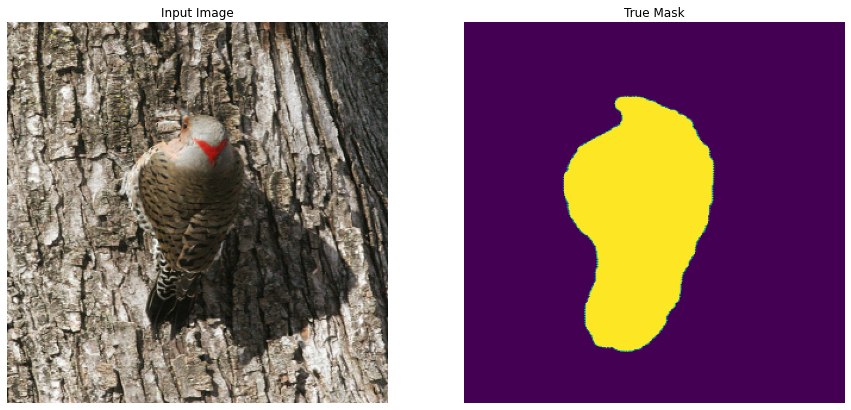

In [10]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

# Model Creation

In [11]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = True
model = tasm.ACFNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

## Define optimizer, losses, metrics and callbacks

In [12]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

metrics = [tasm.metrics.IOUScore(threshold=0.5)]

categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

# Training

In [13]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model: True
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [15]:
start_time = time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
    )

print(f"Model training took {time() - start_time} seconds.")

Epoch 1/3
187/187 [==============================] - 133s 711ms/step - loss: 0.7384 - iou_score: 0.3379 - val_loss: 0.8857 - val_iou_score: 0.0918 - lr: 0.1000
Epoch 2/3
187/187 [==============================] - 134s 716ms/step - loss: 0.7284 - iou_score: 0.3407 - val_loss: 1.0823 - val_iou_score: 0.0805 - lr: 0.1000
Epoch 3/3
187/187 [==============================] - 133s 710ms/step - loss: 0.7179 - iou_score: 0.3463 - val_loss: 0.8560 - val_iou_score: 0.1623 - lr: 0.1000
Model training took 399.72595405578613 seconds.


# Computing Inference Time on 2500 examples

In [16]:
# iou_scores = 0
start_time = time()
for image, mask in test.take(2500):
    output_model = model.predict(image[tf.newaxis, ...])
    
print(f"2500 predictions took about {time() - start_time} seconds.")

2500 predictions took about 243.1182839870453 seconds.
